In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset_train = dsets.MNIST(root='./data/mnist', train=True, transform=transforms.ToTensor(), download=True)
dataset_test = dsets.MNIST(root='./data/mnist', train=False, transform=transforms.ToTensor())

In [5]:
num_train = int(len(dataset_train) * 0.9)  
num_val = len(dataset_train) - num_train

dataset_train, dataset_val = torch.utils.data.random_split(dataset_train, [num_train, num_val])

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

In [11]:
dataset_train[0][0].shape

torch.Size([1, 28, 28])

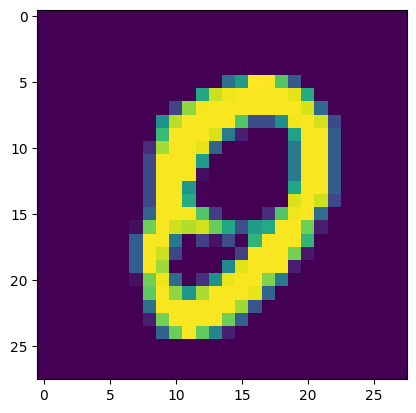

In [9]:
plt.imshow(dataset_train[0][0].numpy()[0,...])

In [33]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 64)
        self.fc3 = nn.Linear(64, classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return torch.log_softmax(self.fc3(x), dim=1)

In [34]:
input_dim = 28 * 28
hidden_dim = 128
classes = 10

net = Net(input_dim, hidden_dim, classes)

cost = torch.nn.NLLLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 10
losses = []

for epoch in range(epochs):
    net.train()

    for x, y in train_loader:
        optim.zero_grad()
        pred = net(x)
        loss = cost(pred, y)
        losses.append(loss.item())
        loss.backward()
        optim.step()

    net.eval()
    with torch.no_grad():
        val_losses = []
        corrects = 0
        for x, y in val_loader:
            pred = net(x)
            _, pval = torch.max(pred, dim=1)
            corrects += (pval == y).sum().item()
            loss = cost(pred, y)
            val_losses.append(loss.item())

    acc = corrects / len(dataset_val)
    print(f'Epoch: {epoch+1}, 训练损失：{np.mean(losses)}, 校验损失：{np.mean(val_losses)}，校验准确率：{acc}')

Epoch: 1, 训练损失：0.24842276681497058, 校验损失：0.27018766311254905，校验准确率：0.9203333333333333
Epoch: 2, 训练损失：0.19709787918149904, 校验损失：0.15601061906744826，校验准确率：0.9538333333333333
Epoch: 3, 训练损失：0.17333090596936795, 校验损失：0.1457228955634414，校验准确率：0.9616666666666667
Epoch: 4, 训练损失：0.15578405728892775, 校验损失：0.15706117080643456，校验准确率：0.9605
Epoch: 5, 训练损失：0.14525635806024043, 校验损失：0.1404177762885043，校验准确率：0.9628333333333333
Epoch: 6, 训练损失：0.13631632757401843, 校验损失：0.1511564147410954，校验准确率：0.963
Epoch: 7, 训练损失：0.12896095603172938, 校验损失：0.17536050611500073，校验准确率：0.9601666666666666
Epoch: 8, 训练损失：0.12461396097263339, 校验损失：0.18140022270876835，校验准确率：0.9626666666666667
Epoch: 9, 训练损失：0.11961936480806351, 校验损失：0.16497749556846758，校验准确率：0.9645
Epoch: 10, 训练损失：0.11418595964243038, 校验损失：0.1758206221894262，校验准确率：0.9638333333333333


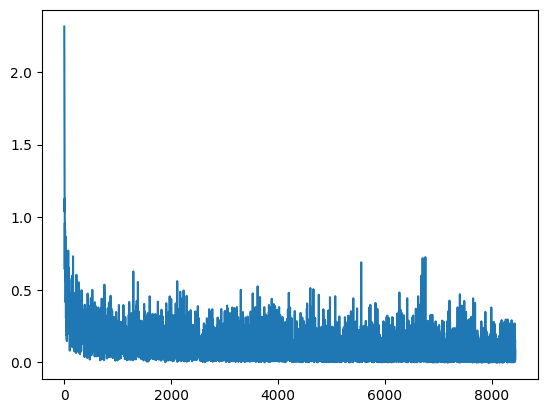

In [36]:
plt.plot(losses)